# Cellular automata for gamma ray track finding
### Spencer R. Deevy | spencer.r.deevy@nasa.gov

In [1]:
# Matplotlib & other data plotting libraries
from matplotlib import pyplot as plt
from matplotlib import ticker as plticker
from matplotlib import collections as mc
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import seaborn
from brewer2mpl import brewer2mpl

# Python Iteration
import itertools

# Numpy 
import numpy as np

# OpenCV
import cv2

# Python timing module
import timeit

# Python bytes to float conversion
import struct

# Show matplotlib figures inline the notebook
%matplotlib inline

In [2]:
##########################################################################################
# rcParams (Publication Quality Graphs)

fig_width_pt = 246.0  					# Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0 		# Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt	# Width in inches
fig_height = fig_width*golden_mean 		# Height in inches
#fig_size =  [fig_width, fig_height]
fig_size =  [7.3,4.2]
params = {'backend': 'pdf',
		'axes.labelsize': 16,
		'legend.fontsize':16,
		'xtick.labelsize': 16,
		'ytick.labelsize': 16,
		'font.family': 'sans-serif',
		'font.sans-serif': 'Avant Garde',
		'font.size': 16,
		'text.usetex': True,
		'figure.figsize': fig_size}

rcParams.update(params)

# Load simulation parameters from initialization file

##### (Initialization file originally named "Ion_elec.dat")

In [3]:
with open("Data/Ion_elec.dat", "rb") as init_file:
    init_file.seek(0)
    sampling_period = struct.unpack('f', init_file.read(4))[0] # Sampling period            - (ms)         - 4 bytes
    total_time = struct.unpack('i', init_file.read(4))[0]      # Total time                 - (ms)         - 4 bytes
    total_passes = struct.unpack('i', init_file.read(4))[0]    # Total readout passes       - (#)          - 4 bytes
    dimensions = struct.unpack('3h', init_file.read(6))        # Voxel dimensions (x, y, z) - (voxel)      - 2 bytes each
    resolutions = struct.unpack('2f', init_file.read(8))       # Resolutions (x/y, z)       - (mm / voxel) - 4 bytes each
    
    # Perform simple check to ensure that at least some of the input paramters are acceptable
    if total_passes == int(round(total_time / sampling_period)):
        print("Simulation parameters: [OK]")
    else:
        print("Simulation parameters: [FAIL]")

Simulation parameters: [OK]


# Load simulation images from streaming data file
##### (Streaming data file originally named "Streaming Data.dat"

In [4]:
# Open streaming data file
with open("Data/Streaming Data.dat", "rb") as streaming_file:
    XZ_raw = [[0 for x in range(dimensions[0])] for z in range(dimensions[2])] 
    YZ_raw = [[0 for y in range(dimensions[0])] for z in range(dimensions[2])]
    
    # Loop over a single volume snapshot (Can be altered for continuous passes)
    for volume in range(0, 1):
        
        # Build full volume images (XZ and YZ)
        for current_pass in range(0, dimensions[2]/2):
            pass_number = struct.unpack('i', streaming_file.read(4))[0]             # Current pass number
            lx_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower x hits in current pass
            lx_hit_pos = struct.unpack('i'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit positions in current pass
            lx_hit_sig = struct.unpack('f'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit electrons in current pass
            ly_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower y hits in current pass
            ly_hit_pos = struct.unpack('i'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit positions in current pass
            ly_hit_sig = struct.unpack('f'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit electrons in current pass
            ux_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of upper x hits in current pass
            ux_hit_pos = struct.unpack('i'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit positions in current pass
            ux_hit_sig = struct.unpack('f'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit electrons in current pass
            uy_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of Upper y hits in current pass
            uy_hit_pos = struct.unpack('i'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit positions in current pass
            uy_hit_sig = struct.unpack('f'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit electrons in current pass
            
            # Populate raw XZ data for lower x hits
            for i in range(0, lx_hits):
                XZ_raw[current_pass][lx_hit_pos[i]] = lx_hit_sig[i]
                
            # Populate raw XZ data for upper x hits
            for i in range(0, ux_hits):
                XZ_raw[dimensions[2] - current_pass - 1][ux_hit_pos[i]] = ux_hit_sig[i]
                
            # Populate raw YZ data for lower y hits
            for i in range(0, ly_hits):
                YZ_raw[current_pass][ly_hit_pos[i]] = ly_hit_sig[i]
                
            # Populate raw YZ data for upper y hits
            for i in range(0, uy_hits):
                YZ_raw[dimensions[2] - current_pass - 1][uy_hit_pos[i]] = uy_hit_sig[i]

# Plot volume snapshot for XZ and YZ projections

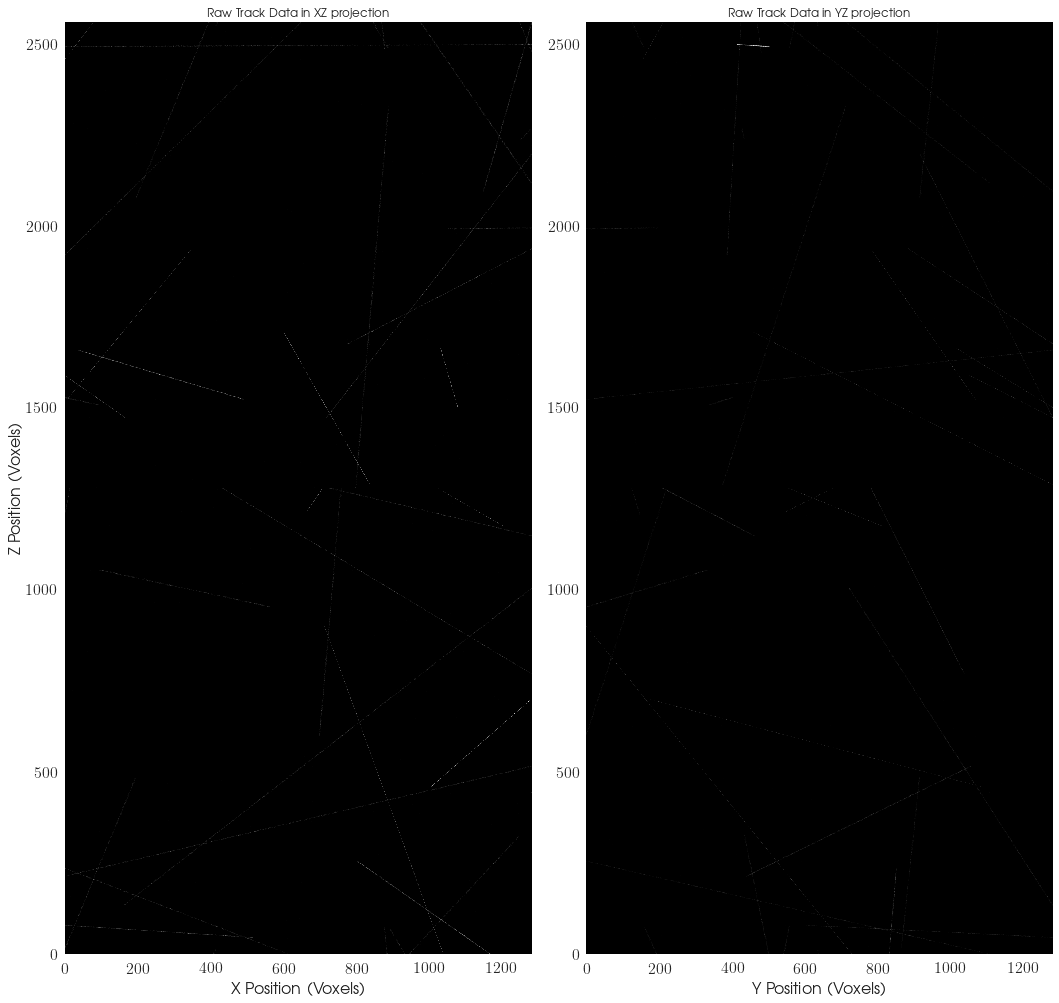

In [5]:
# Plot raw data for XZ and YZ snapshots 
raw_fig, (ax_raw_XZ, ax_raw_YZ) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15.5))

# Convert to numpy arrays
raw_XZ = np.array(XZ_raw)
raw_YZ = np.array(YZ_raw)

ax_raw_XZ.imshow(raw_XZ, "Greys_r", origin='lower') 
ax_raw_YZ.imshow(raw_YZ, "Greys_r", origin='lower')

ax_raw_XZ.grid(False)
ax_raw_YZ.grid(False)

ax_raw_XZ.set_xlabel('X Position (Voxels)')
ax_raw_YZ.set_xlabel('Y Position (Voxels)')
ax_raw_XZ.set_ylabel('Z Position (Voxels)')

ax_raw_XZ.set_title('Raw Track Data in XZ projection')
ax_raw_YZ.set_title('Raw Track Data in YZ projection')

plt.tight_layout() # Spaces titles out properly
plt.show()